In [1]:
# Import of necessary packages
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import NearestNeighbors
from random import randint
import seaborn as sns
import pandasgui

In [2]:
# %% Variables & Switches 
do_preprocessing = 1

In [3]:
# %% Functions
# This function is used to calculate a result table including the relative and absolute deviation between two values
def create_resultstable(y_pred, y_test):
    results = pd.DataFrame([y_pred, y_test], index = ['y_predicted','y_test']).T
    results['deviations'] = results['y_predicted'] - results['y_test']
    results['rel_deviation'] = results['deviations']/results['y_test']
    results['abs_rel_deviation'] = abs(results['deviations']/results['y_test'])
    return results

In [4]:
# This function analyzes the deviation result table in cases of quantity splits
def table_deviation_per_quantity(results_table):
    dev_1 = results_table[results_table['y_test']<50]['abs_rel_deviation']
    dev_2 = results_table[(results_table['y_test']>50) & (results_table['y_test']<100)]['abs_rel_deviation']
    dev_3 = results_table[(results_table['y_test']>100) & (results_table['y_test']<150)]['abs_rel_deviation']
    dev_4 = results_table[(results_table['y_test']>150) & (results_table['y_test']<200)]['abs_rel_deviation']
    dev_5 = results_table[(results_table['y_test']>200)]['abs_rel_deviation']
    dev_quantity = pd.DataFrame([dev_1.describe(), dev_2.describe(), dev_3.describe(), dev_4.describe(), dev_5.describe()],
            index = ['0-50','50-100','100-150','150-200','>200']).T
    return dev_quantity

In [5]:
# This function plots the relative deviations
def plot_relative_deviation(results, ylimit):
    plt.figure(figsize = (12,8))
    plt.scatter(x = results['y_test'].values, y = results['rel_deviation'].values*100, s = 8)
    plt.xlabel('Q [mm^3]')
    plt.ylabel('Rel. error [%]')
    plt.plot([0,250], [3.6, 3.6], 'k-')
    plt.plot([0,250], [-3.6, -3.6], 'k-')
    axes = plt.gca()
    axes.set_ylim([-ylimit,ylimit])
    plt.show()

In [6]:
# Model training incl. plotting the result deviation
def percentage_split_eval(regression_model, X_train, y_train, ylimit):
    regression_model.fit(X_train, y_train)
    y_predicted = regression_model.predict(X_train)
    results = create_resultstable(y_predicted, y_train)
    print("Mean absolute error on training set", 
          mean_absolute_error(regression_model.predict(X_train), y_train))
    print("")
    results_per_quantity = table_deviation_per_quantity(results)
    display(results_per_quantity)
    plot_relative_deviation(results, ylimit)
    return(results_per_quantity)

In [7]:
# Tsting of model incl. plotting the result deviation
def percentage_split_test(regression_model, X_test, y_test, ylimit):
    y_predicted = regression_model.predict(X_test)
    results = create_resultstable(y_predicted, y_test)
    print("Mean absolute error on test set",mean_absolute_error(y_pred=y_predicted, y_true=y_test))
    results_per_quantity = table_deviation_per_quantity(results)
    display(results_per_quantity)
    plot_relative_deviation(results, ylimit)
    return(results_per_quantity)

In [8]:
# %% Load Data
#Training Data
dataTrain = pd.read_csv('../data/Trainingdata_p4m.csv',';')
# Test Data
dataTest = pd.read_csv('../data/Testdata_p4m.csv',';')

In [9]:
dataTrain.columns

Index(['Q_Inj [mm3]', 'nEng [rpm]', 'p_transient_1 [bar]',
       'p_transient_2 [bar]', 'p_transient_3 [bar]', 'p_transient_4 [bar]',
       'p_transient_5 [bar]', 'p_transient_6 [bar]', 'p_transient_7 [bar]',
       'p_transient_8 [bar]', 'p_transient_9 [bar]', 'p_transient_10 [bar]',
       'p_transient_11 [bar]', 'p_transient_12 [bar]', 'p_transient_13 [bar]',
       'p_transient_14 [bar]', 'p_transient_15 [bar]', 'p_transient_16 [bar]',
       'p_transient_17 [bar]', 'p_transient_18 [bar]', 'p_transient_19 [bar]',
       'p_transient_20 [bar]', 'phiMI [GradCrA]'],
      dtype='object')

array([[<AxesSubplot:title={'center':'Q_Inj [mm3]'}>,
        <AxesSubplot:title={'center':'nEng [rpm]'}>,
        <AxesSubplot:title={'center':'p_transient_1 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_2 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_3 [bar]'}>],
       [<AxesSubplot:title={'center':'p_transient_4 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_5 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_6 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_7 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_8 [bar]'}>],
       [<AxesSubplot:title={'center':'p_transient_9 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_10 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_11 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_12 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_13 [bar]'}>],
       [<AxesSubplot:title={'center':'p_transient_14 [bar]'}>,
        <AxesSubp

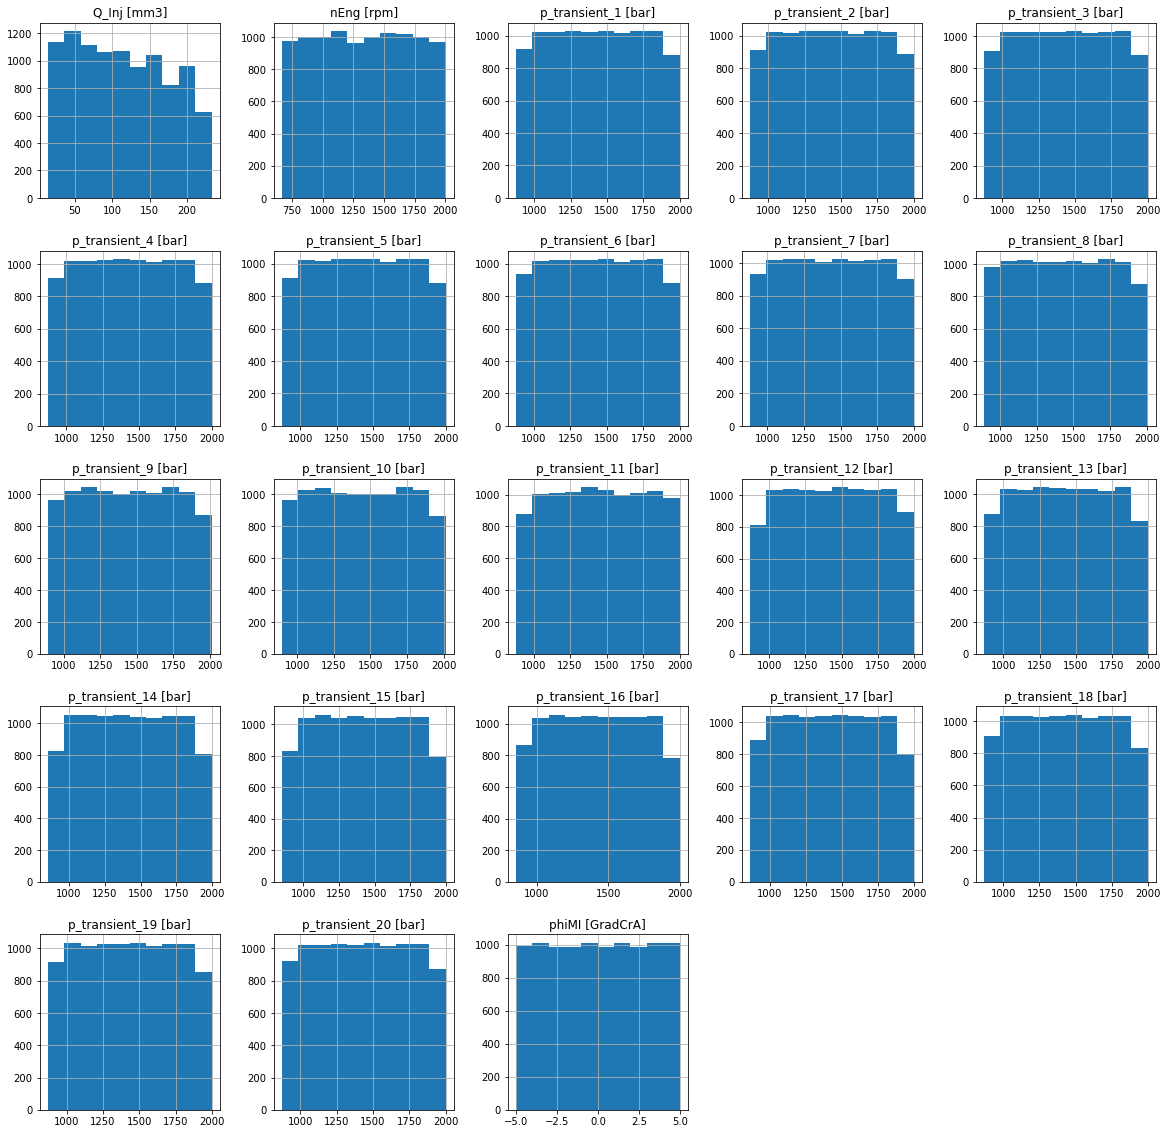

In [10]:
dataTrain.hist(figsize=(20,20))

In [11]:
transients = [f"p_transient_{i} [bar]" for i in range(1, 21)]
features = ['nEng [rpm]'] + transients

In [12]:
def preprocess(df):
    # Correct by maximum pressure
    # after this transformation, all transient measurement series will have their max value at 0.
    df.loc[:,transients] = df.loc[:, transients].sub(df.loc[:, transients].max(axis=1), axis=0)
    df['p_drop']=-df.loc[:, transients].min(axis=1)
    return df

In [13]:
# %% Data Preprocessing
if do_preprocessing==1:
    dataTrain = preprocess(dataTrain)
    dataTest = preprocess(dataTest)

In [14]:
pandasgui.show(dataTrain)

array([[<AxesSubplot:title={'center':'Q_Inj [mm3]'}>,
        <AxesSubplot:title={'center':'nEng [rpm]'}>,
        <AxesSubplot:title={'center':'p_transient_1 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_2 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_3 [bar]'}>],
       [<AxesSubplot:title={'center':'p_transient_4 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_5 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_6 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_7 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_8 [bar]'}>],
       [<AxesSubplot:title={'center':'p_transient_9 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_10 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_11 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_12 [bar]'}>,
        <AxesSubplot:title={'center':'p_transient_13 [bar]'}>],
       [<AxesSubplot:title={'center':'p_transient_14 [bar]'}>,
        <AxesSubp

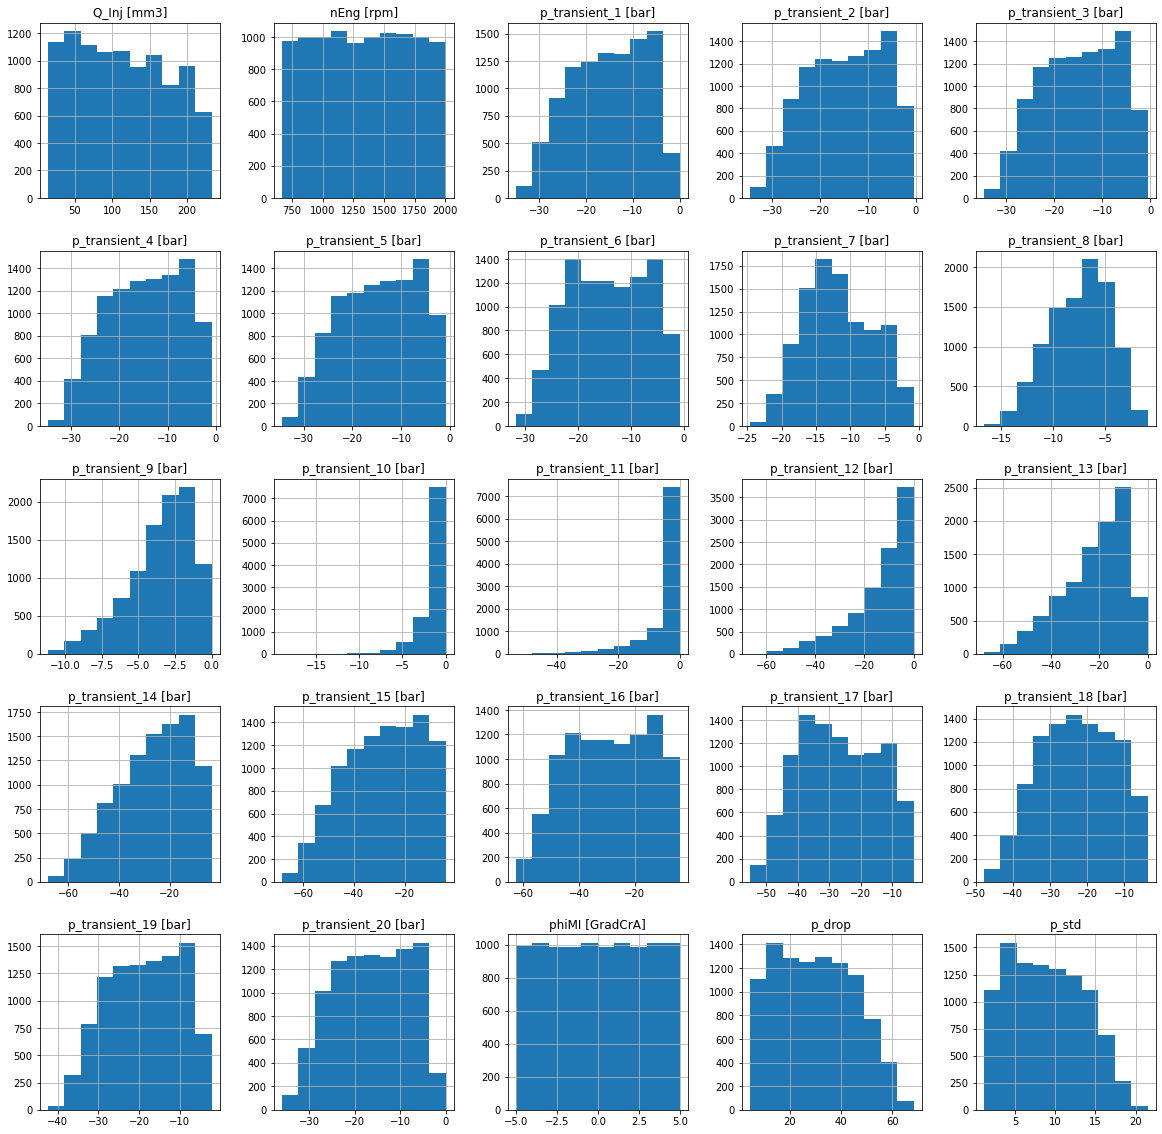

In [54]:
dataTrain.hist(figsize=(20,20))

Index(['Q_Inj [mm3]', 'nEng [rpm]', 'p_transient_1 [bar]',
       'p_transient_2 [bar]', 'p_transient_3 [bar]', 'p_transient_4 [bar]',
       'p_transient_5 [bar]', 'p_transient_6 [bar]', 'p_transient_7 [bar]',
       'p_transient_8 [bar]', 'p_transient_9 [bar]', 'p_transient_10 [bar]',
       'p_transient_11 [bar]', 'p_transient_12 [bar]', 'p_transient_13 [bar]',
       'p_transient_14 [bar]', 'p_transient_15 [bar]', 'p_transient_16 [bar]',
       'p_transient_17 [bar]', 'p_transient_18 [bar]', 'p_transient_19 [bar]',
       'p_transient_20 [bar]', 'phiMI [GradCrA]', 'p_drop', 'p_std'],
      dtype='object')
       Q_Inj [mm3]   nEng [rpm]  p_transient_1 [bar]  p_transient_2 [bar]  \
count  9992.000000  9992.000000          9992.000000          9992.000000   
mean    114.362045  1333.086227           -15.300591           -14.812952   
std      60.797061   385.066917             7.933813             7.987252   
min      13.799000   666.520000           -35.000000           -34.600000  

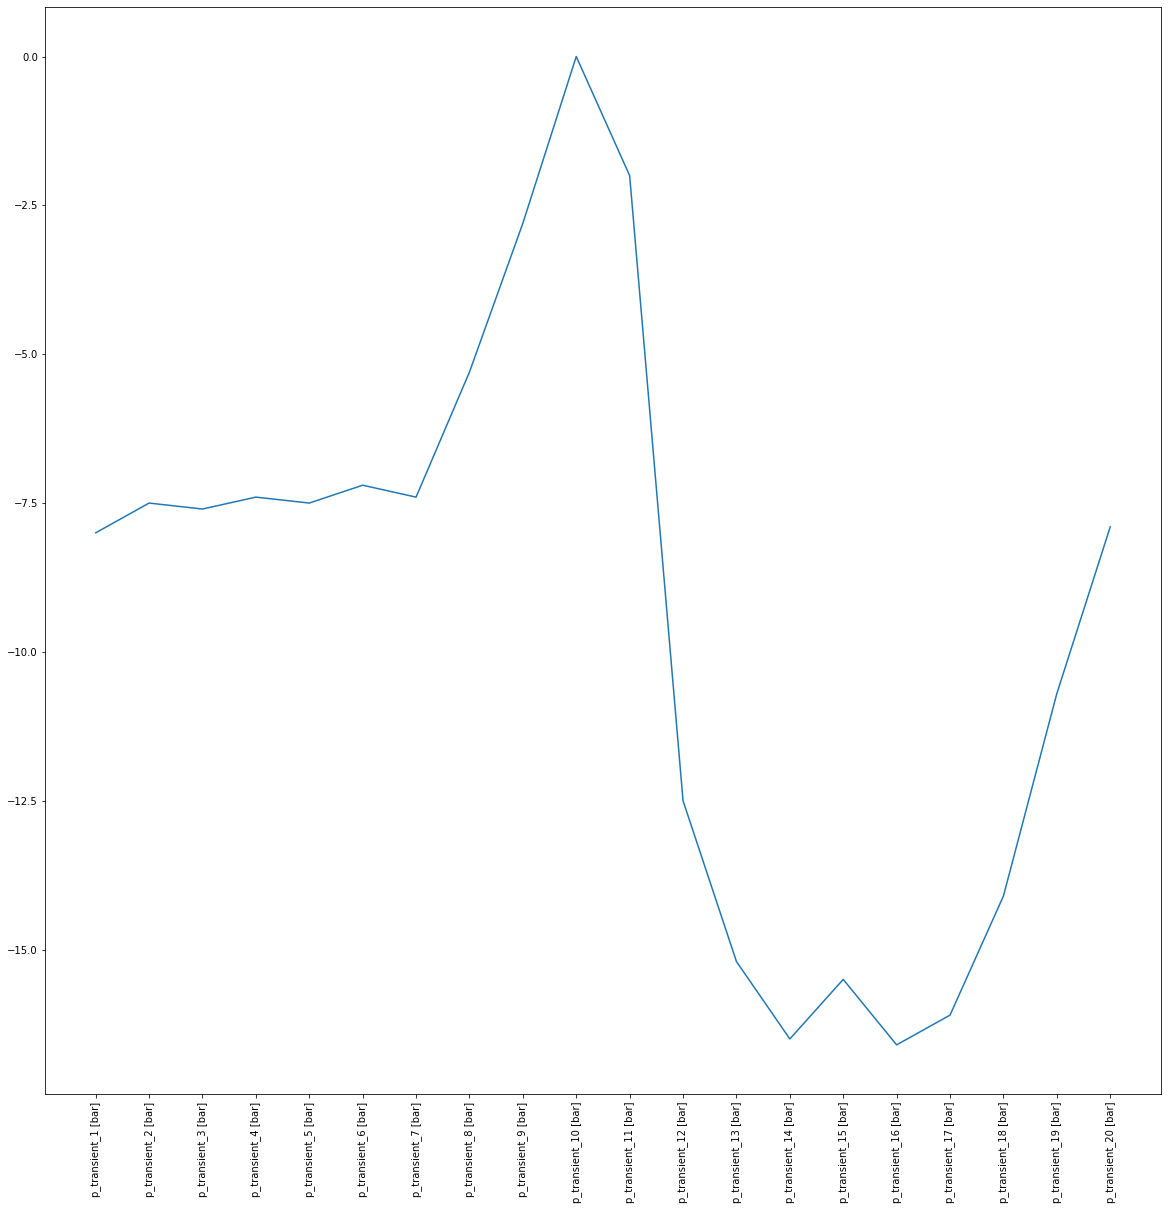

Q: 63.123999999999995
Max: 0.0 Min: -16.59999999999991 Diff: 16.59999999999991
Max_ber: 0.0 Min_ber: -16.59999999999991


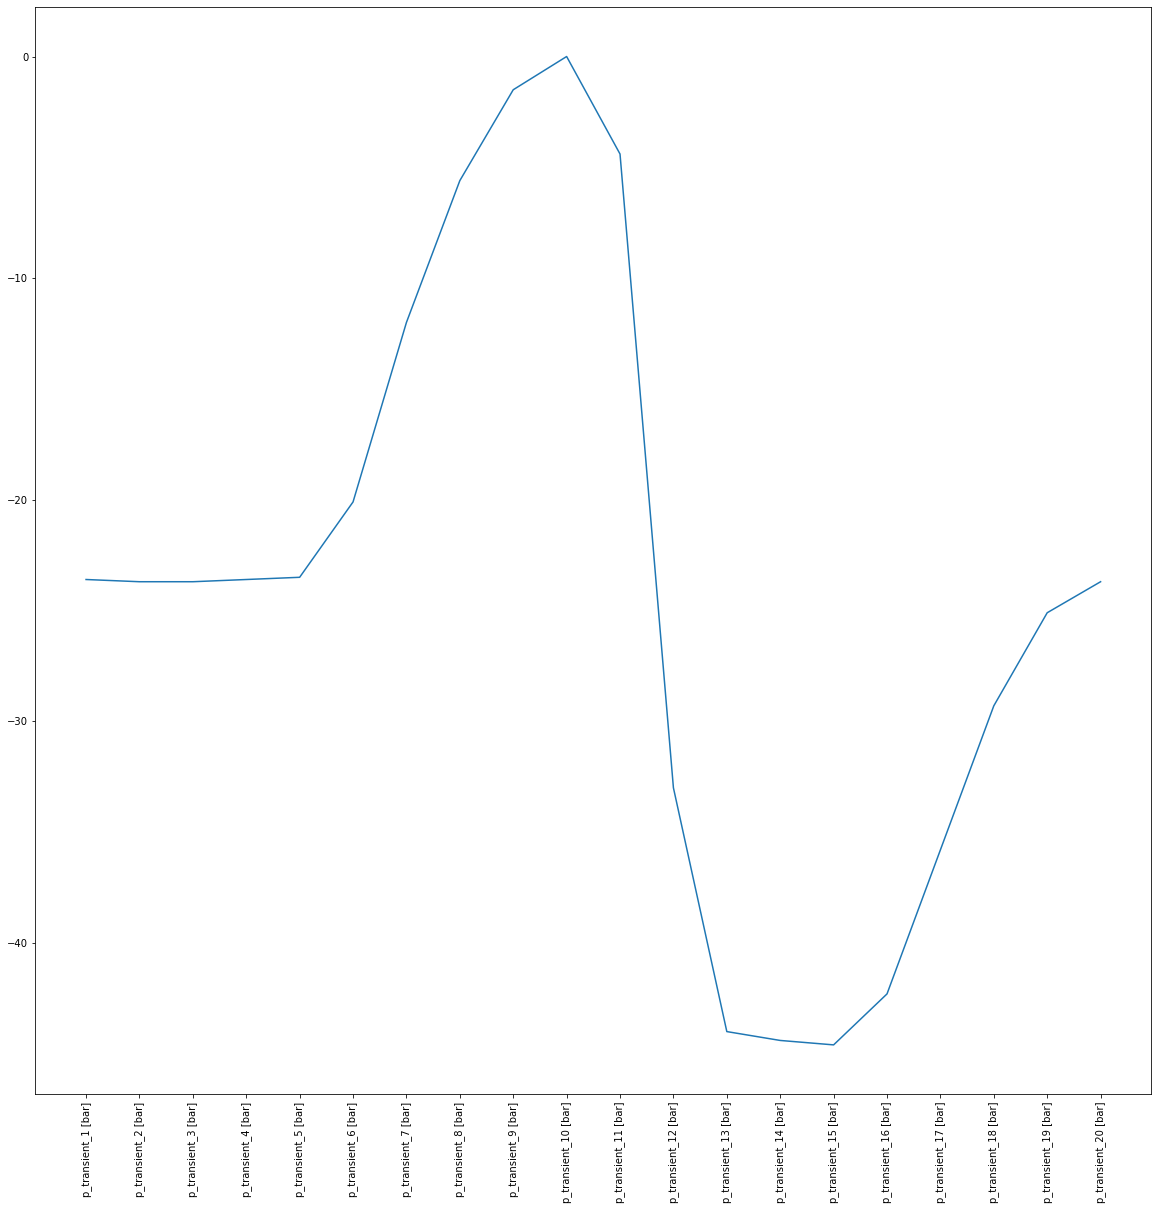

Q: 180.07
Max: 0.0 Min: -44.59999999999991 Diff: 44.59999999999991
Max_ber: 0.0 Min_ber: -44.59999999999991
[[ 1.         -0.96436821]
 [-0.96436821  1.        ]]


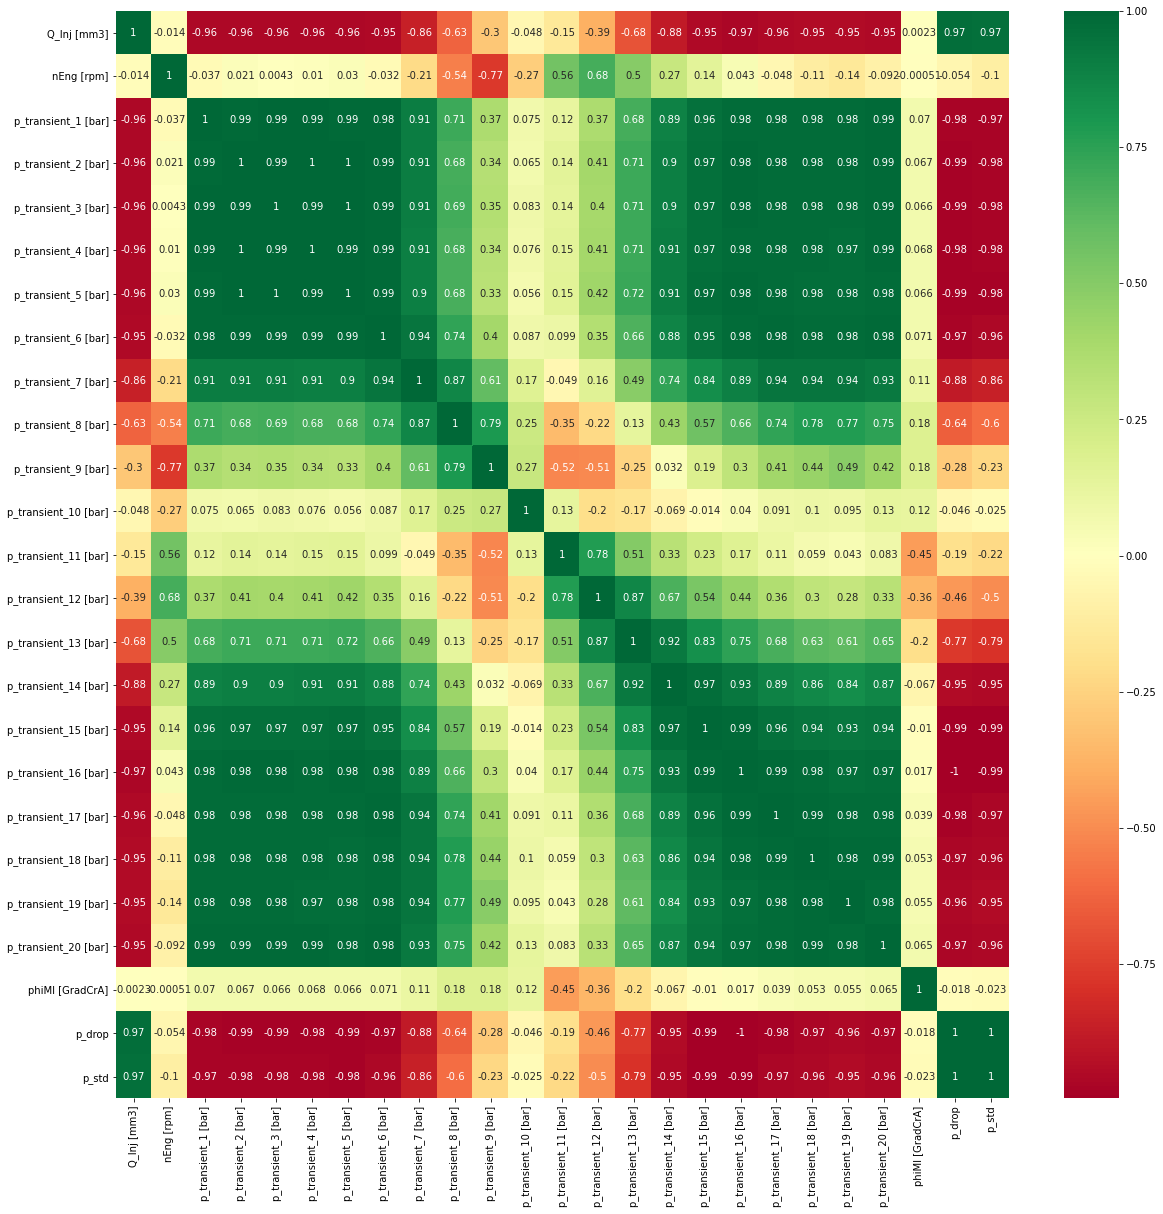

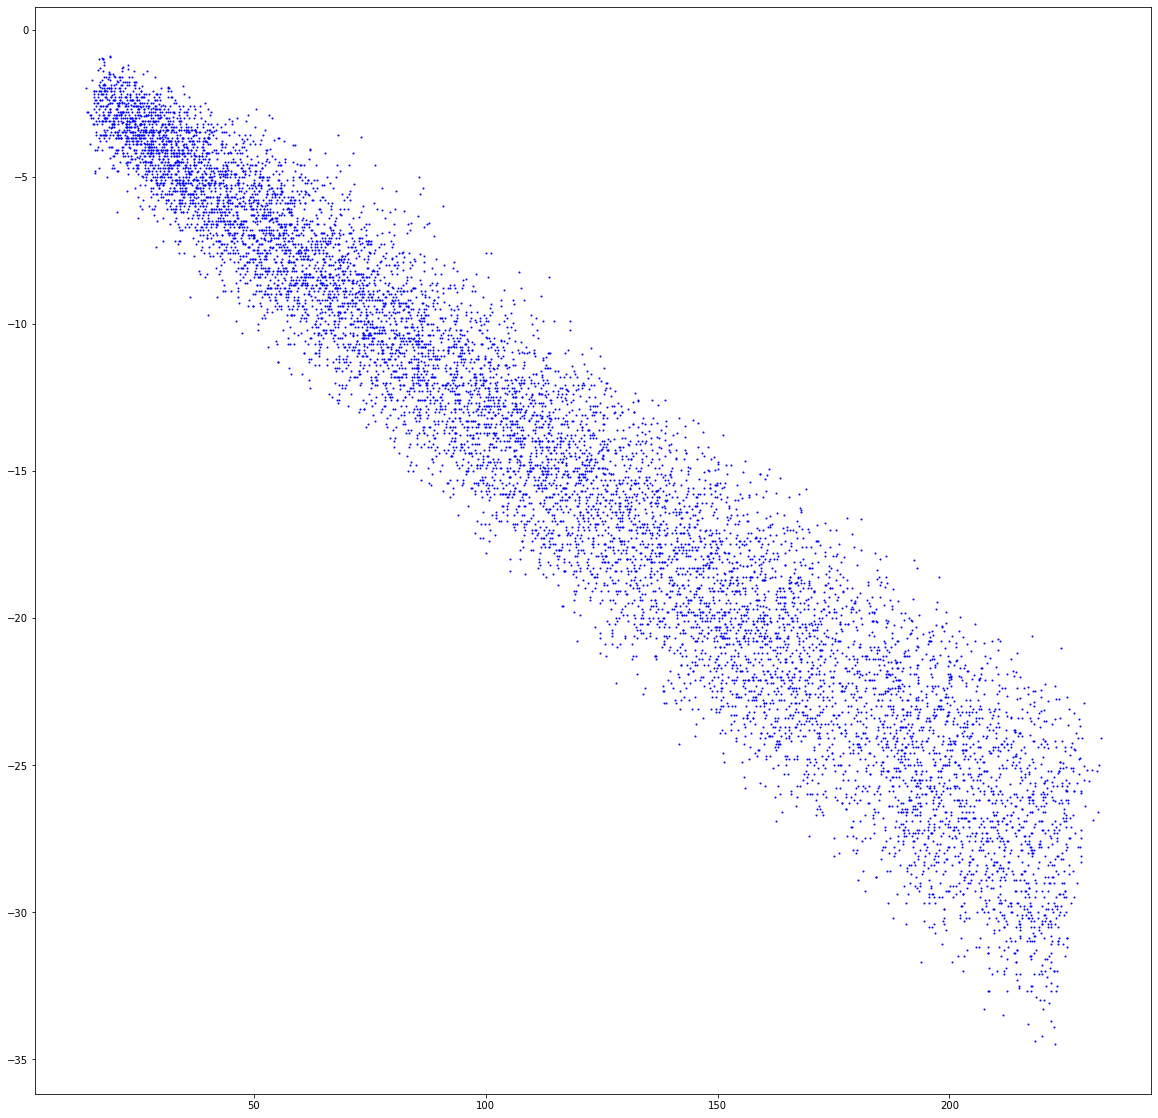

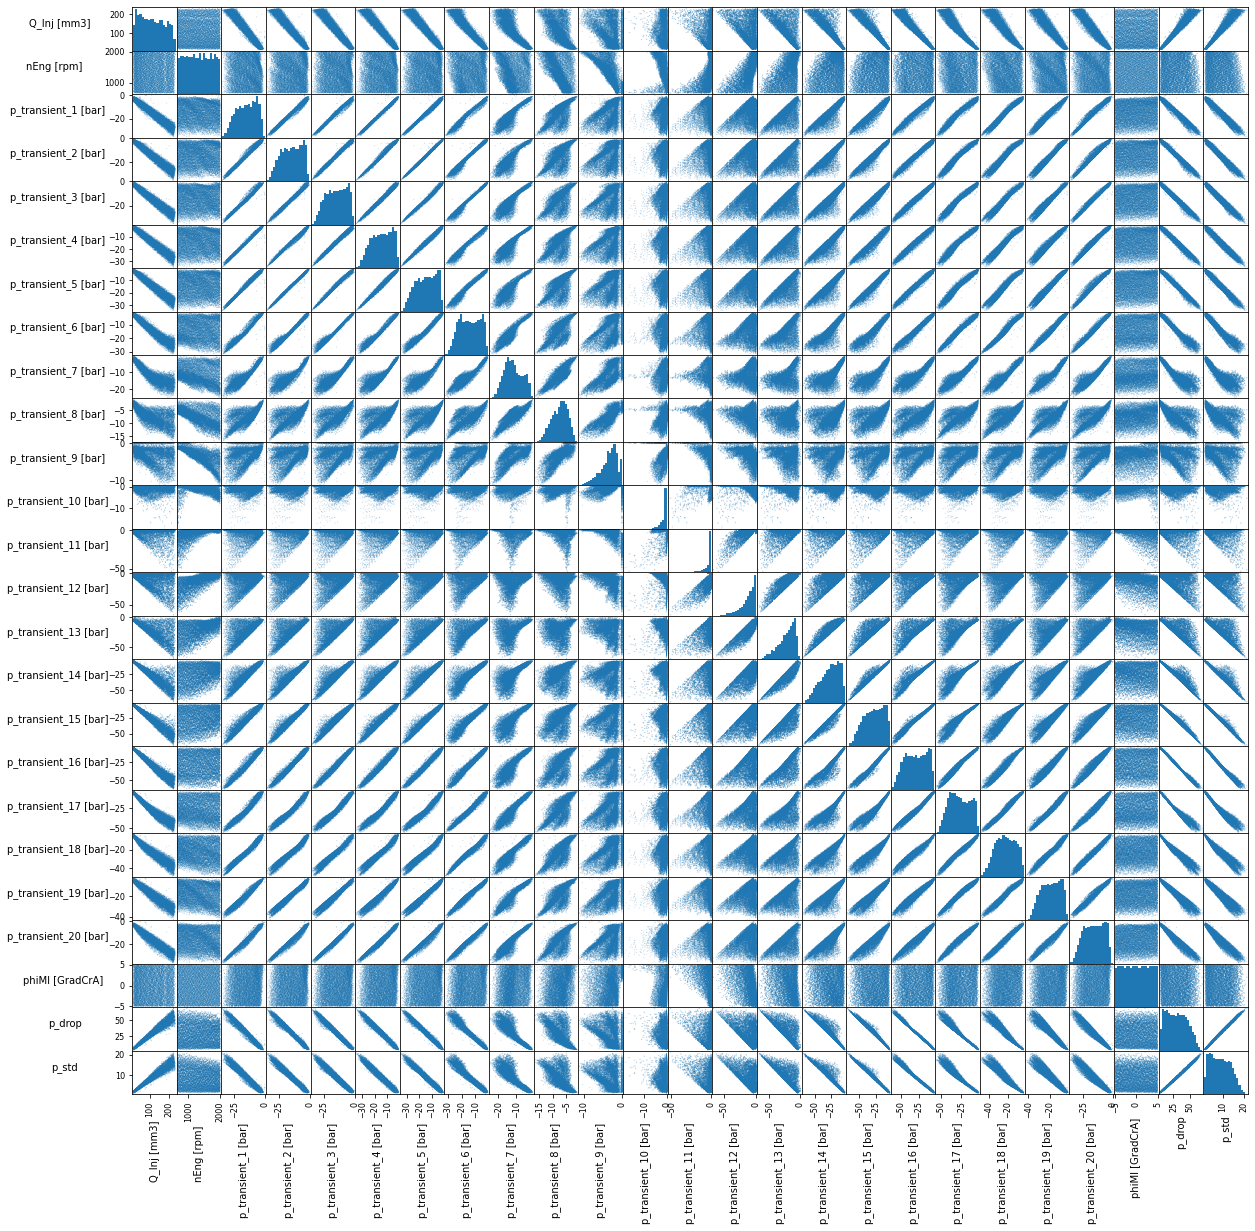

In [55]:
# %% Data analysis
# Analyse names of Data Frame columns
print(dataTrain.columns)
# Analyse values of each column
print(dataTrain.describe())
# Plot for a given number pressure curves
number_of_plots = 2
random_numbers = [randint(0,dataTrain.shape[0]) for p in range(0,number_of_plots)]
print(random_numbers)
for i in random_numbers:
    plt.plot(dataTrain.loc[i,transients])
    plt.xticks(rotation=90)
    plt.show()
    print("Q:", dataTrain.loc[i,"Q_Inj [mm3]"])
    print("Max:", dataTrain.loc[i,transients].max(), "Min:", dataTrain.loc[i,transients].min(),
         "Diff:", dataTrain.loc[i,transients].values.max() - dataTrain.loc[i,transients].min())
    print("Max_ber:", dataTrain.loc[i,transients].max(), "Min_ber:", dataTrain.loc[i,transients].min())
# Calculate correlation coefficients for two columns
Coeff = np.corrcoef(dataTrain['Q_Inj [mm3]'], dataTrain['p_transient_5 [bar]'])
print(Coeff)
#Plotting a correlation plot (all in one)
plt.rcParams["figure.figsize"] = (20,20)
sns.heatmap(dataTrain.corr(), annot=True, cmap="RdYlGn")
plt.show()
# Plot correlation of two columns
plt.plot(dataTrain['Q_Inj [mm3]'], dataTrain['p_transient_5 [bar]'], 'bo', markersize=1)
# Create a scatter matrix from the dataframe (all in one)
axs = scatter_matrix(dataTrain, figsize=(20, 20), marker='o', hist_kwds={'bins': 20}, s=1, alpha=.3)
n = len(dataTrain.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

C:\Users\GRM2RNG\.conda\envs\m2move\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Mean absolute error on training set 3.569290547061801



,0-50,50-100,100-150,150-200,>200
count,1918.000000,2523.000000,2342.000000,2142.000000,1066.000000
mean,0.131765,0.051160,0.025868,0.019083,0.021026
std,0.132593,0.043941,0.020853,0.016507,0.018364
min,0.000209,0.000017,0.000035,0.000022,0.000097
25%,0.044559,0.019549,0.010114,0.006724,0.007893
50%,0.096898,0.041099,0.020906,0.015411,0.016889
75%,0.170445,0.072813,0.036372,0.026682,0.028687
max,1.077749,0.669838,0.190057,0.137542,0.161949


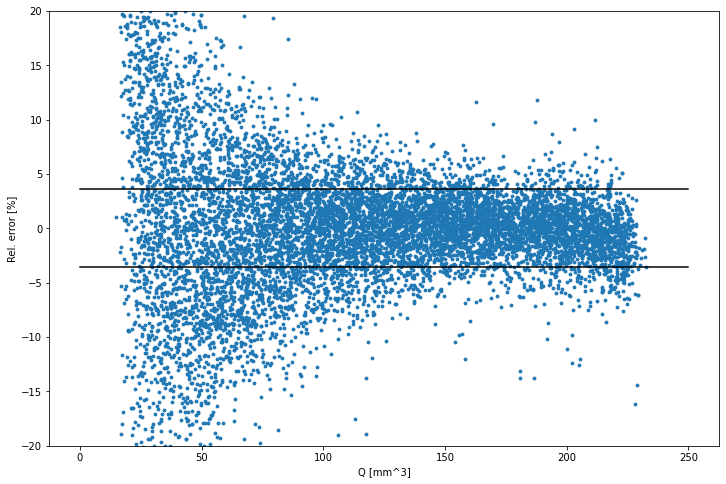

In [56]:
# %% Regression model building
# Define input & output variables used for training
xTrain = dataTrain.loc[:,features].values
yTrain = dataTrain['Q_Inj [mm3]']
# Scale input variables to range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(xTrain)
xTrain_scaled = pd.DataFrame(scaler.transform(xTrain))
# Set model parameters for Neural Network
alpha = 0.0001
neurons = (3,)
solver_chosen = 'lbfgs'
activation_function = 'logistic'
maximum_iterations = 10000
simple_mlp_reg = MLPRegressor(hidden_layer_sizes=neurons, activation=activation_function, solver = solver_chosen, max_iter=maximum_iterations)
# Calculating & evaluating regression with training data
table_per_quantity = percentage_split_eval(simple_mlp_reg, xTrain_scaled, yTrain, 20)

Mean absolute error on test set 4.780910493285554


,0-50,50-100,100-150,150-200,>200
count,1601.000000,2385.000000,3553.000000,1843.000000,3971.000000
mean,0.259369,0.072637,0.032702,0.037529,0.019021
std,0.291847,0.120253,0.141153,0.179771,0.092489
min,0.000133,0.000013,0.000005,0.000008,0.000004
25%,0.060995,0.024739,0.007198,0.005631,0.005577
50%,0.146978,0.053870,0.015962,0.012556,0.011255
75%,0.391291,0.089233,0.027307,0.022875,0.019090
max,2.646373,2.152144,2.034443,1.877597,1.724688


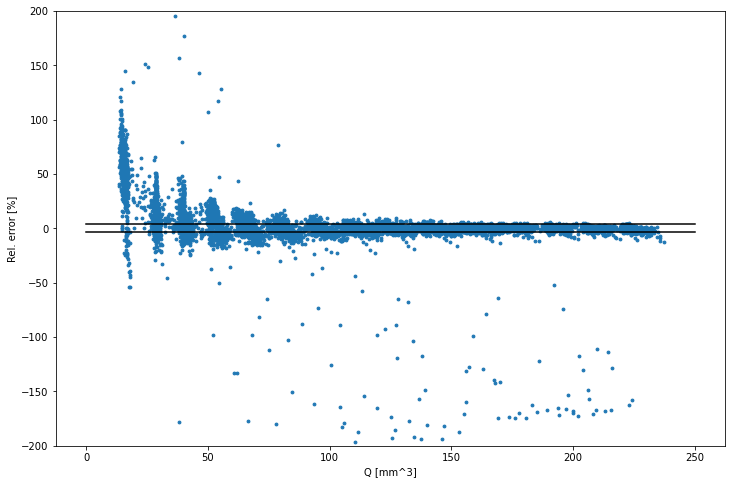

In [57]:
# %% Testing regression model
# Define input & output variables used for testing (must be equal to training variables)
xTest = dataTest.loc[:,features].values
yTest = dataTest['Q_Inj [mm3]']
# Scale input variables to range from -1 to 1
xTest_scaled = pd.DataFrame(scaler.transform(xTest))
# Evaluating regression with test data
table_per_quantity = percentage_split_test(simple_mlp_reg, xTest_scaled, yTest, 200)

Mean absolute error on test set 9.934008024239652


,0-50,50-100,100-150,150-200,>200
count,41.000000,511.000000,686.000000,1096.000000,3796.000000
mean,1.606621,0.259733,0.168226,0.082480,0.023382
std,1.529537,0.791653,0.648196,0.409652,0.149517
min,0.003838,0.000118,0.000033,0.000009,0.000012
25%,0.173691,0.026532,0.010367,0.005238,0.005726
50%,1.205758,0.053016,0.023308,0.012611,0.011886
75%,3.018658,0.097186,0.042627,0.024592,0.019987
max,5.286763,4.677255,3.930812,3.155982,2.689689


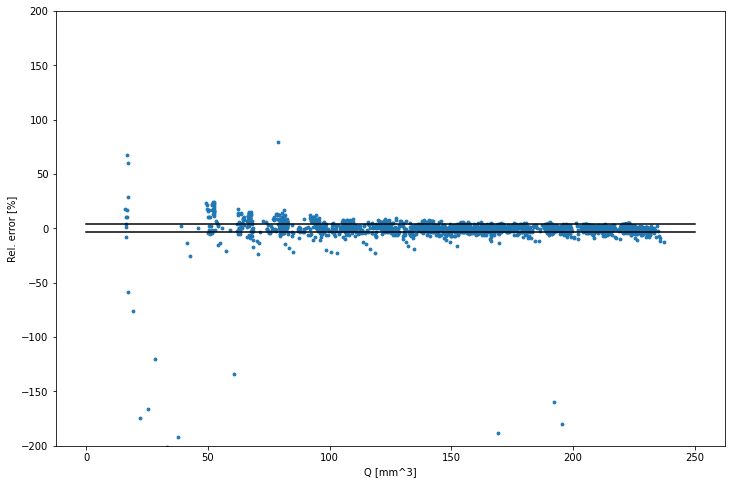

Mean absolute error on test set 3.437331225409813


,0-50,50-100,100-150,150-200,>200
count,1560.000000,1874.000000,2867.000000,747.000000,175.000000
mean,0.236831,0.064299,0.018679,0.014806,0.016198
std,0.235361,0.049279,0.016530,0.011535,0.009380
min,0.000308,0.000007,0.000005,0.000015,0.000320
25%,0.055868,0.025749,0.006884,0.005854,0.009431
50%,0.137412,0.056211,0.014791,0.012334,0.015854
75%,0.370098,0.091635,0.025901,0.021528,0.022794
max,1.234012,0.347026,0.127279,0.092226,0.039660


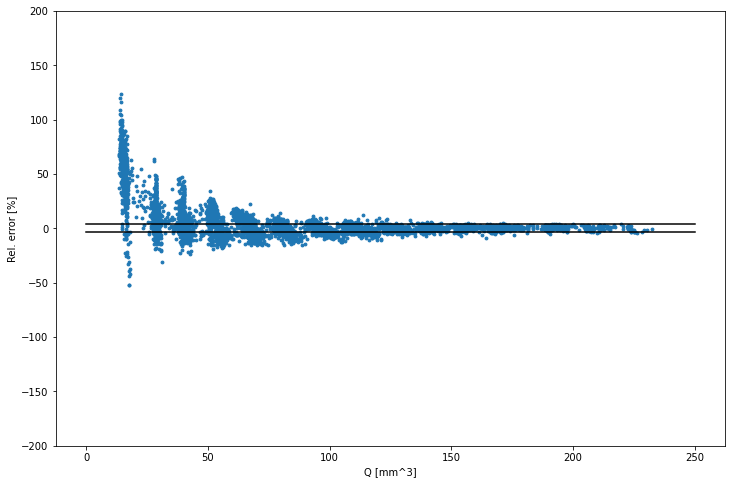

In [14]:
# %% Outlier detection
## Set parameters for nearest neighbors
number_of_neighbors=10
# Fit model on training data
nbrs = NearestNeighbors(n_neighbors=number_of_neighbors, algorithm='ball_tree').fit(xTrain_scaled)
# Calculate distances of test data compared to model
distances, neighbourpoints = nbrs.kneighbors(xTest_scaled)
# Define distance to split data in outlier and non-outlier
allowed_distance = 0.3
# Split test data in outlier and non-outlier
xTest_scaled_out = xTest_scaled[distances[:,9]>allowed_distance]
yTest_out = yTest[distances[:,9]>allowed_distance]
xTest_scaled_no_out = xTest_scaled[distances[:,9]<allowed_distance]
yTest_no_out = yTest[distances[:,9]<allowed_distance]
# Test with outlier and non-outlier
# Outlier
table_per_quantity = percentage_split_test(simple_mlp_reg, xTest_scaled_out, yTest_out, 200)
# Non-Outlier
table_per_quantity = percentage_split_test(simple_mlp_reg, xTest_scaled_no_out, yTest_no_out, 200)